<a href="https://colab.research.google.com/github/bforsbe/SK2534/blob/main/omegafold_znf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**OmegaFold**
for more details see: [Github](https://github.com/HeliXonProtein/OmegaFold), [Preprint](https://www.biorxiv.org/content/10.1101/2022.07.21.500999v1)

#### **Tips and Instructions**
- click the little ▶ play icon to the left of each cell below.
- use "/" to specify chainbreaks, (eg. sequence="AAA/AAA")
- for homo-oligomeric predictions, set copies > 1


In [1]:
#@markdown ##Install
import os,sys,re
from IPython.utils import io
if "SETUP_DONE" not in dir():
  import torch
  device = "cuda" if torch.cuda.is_available() else "cpu"
  with io.capture_output() as captured:
    if not os.path.isdir("OmegaFold"):
      %shell git clone --branch beta --quiet https://github.com/sokrypton/OmegaFold.git
      # %shell cd OmegaFold; pip -q install -r requirements.txt
      %shell pip -q install py3Dmol biopython==1.81
      %shell apt-get install aria2 -qq > /dev/null
      %shell aria2c -q -x 16 https://helixon.s3.amazonaws.com/release1.pt
      %shell mkdir -p ~/.cache/omegafold_ckpt
      %shell mv release1.pt ~/.cache/omegafold_ckpt/model.pt
  SETUP_DONE = True

In [2]:
#@markdown ##Run **OmegaFold**
from string import ascii_uppercase, ascii_lowercase
import hashlib
import torch
from IPython.utils import io

# Define device here to ensure it's available
device = "cuda" if torch.cuda.is_available() else "cpu"

def get_hash(x): return hashlib.sha1(x.encode()).hexdigest()
alphabet_list = list(ascii_uppercase+ascii_lowercase)

jobname = "1ZNF" #@param {type:"string"}
jobname = re.sub(r'\W+', '', jobname)[:50]

sequence = "YKCGLCERSFVEKSALSRHQRVHKN" #@param {type:"string"}
sequence = re.sub("[^A-Z:]", "", sequence.replace("/",":").upper())
sequence = re.sub(":+",":",sequence)
sequence = re.sub("^[:]+","",sequence)
sequence = re.sub("[:]+$","",sequence)

copies = 1 #@param {type:"integer"}
sequence = ":".join([sequence] * copies)
#@markdown **Advanced Options**
num_cycle = 2 #@param ["1", "2", "4", "8", "16", "32"] {type:"raw"}
offset_rope = False #@param {type:"boolean"}

ID = jobname+"_"+get_hash(sequence)[:5]
seqs = sequence.split(":")
lengths = [len(s) for s in seqs]

subbatch_size = 1000 #@param
def get_subbatch_size(L):
  if L <  500: return 500
  if L < 1000: return 200
  return 150
if subbatch_size < 0:
    subbatch_size = get_subbatch_size(sum(lengths))

u_seqs = list(set(seqs))

if len(seqs) == 1: mode = "mono"
elif len(u_seqs) == 1: mode = "homo"
else: mode = "hetero"

with open(f"{ID}.fasta","w") as out:
  out.write(f">{ID}\n{sequence}\n")

# Construct the shell command, handling the boolean offset_rope
shell_command = f"python OmegaFold/main.py --device={device} --subbatch_size={subbatch_size} --num_cycle={num_cycle} {ID}.fasta ."
if offset_rope:
    shell_command = f"python OmegaFold/main.py --offset_rope --device={device} --subbatch_size={subbatch_size} --num_cycle={num_cycle} {ID}.fasta ."

%shell {shell_command}

def renum_pdb_str(pdb_str, Ls=None, renum=True, offset=1):
  if Ls is not None:
    L_init = 0
    new_chain = {}
    for L,c in zip(Ls, alphabet_list):
      new_chain.update({i:c for i in range(L_init,L_init+L)})
      L_init += L

  n,num,pdb_out = 0,offset,[]
  resnum_ = None
  chain_ = None
  new_chain_ = new_chain[0]
  for line in pdb_str.split("\n"):
    if line[:4] == "ATOM":
      chain = line[21:22]
      resnum = int(line[22:22+5])
      if resnum_ is None: resnum_ = resnum
      if chain_ is None: chain_ = chain
      if resnum != resnum_ or chain != chain_:
        num += (resnum - resnum_)
        n += 1
        resnum_,chain_ = resnum,chain
      if Ls is not None:
        if new_chain[n] != new_chain_:
          num = offset
          new_chain_ = new_chain[n]
      N = num if renum else resnum
      if Ls is None: pdb_out.append("%s%4i%s" % (line[:22],N,line[26:]))
      else: pdb_out.append("%s%s%4i%s" % (line[:21],new_chain[n],N,line[26:]))
  return "\n".join(pdb_out)

pdb_str = renum_pdb_str(open(f"{ID}.pdb",'r').read(), Ls=lengths)
o_pdb_file=f"{ID}.pdb"
with open(o_pdb_file,"w") as out:
  out.write(pdb_str)

/usr/local/lib/python3.12/dist-packages/Bio/Data/SCOPData.py:18: BiopythonDeprecationWarning: The 'Bio.Data.SCOPData' module will be deprecated in a future release of Biopython in favor of 'Bio.Data.PDBData.
  warnings.warn(
/content/OmegaFold/omegafold/utils/protein_utils/residue_constants.py:483: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /pytorch/aten/src/ATen/native/Cross.cpp:63.)
  eznorm = torch.cross(ex_normalized, ey_normalized)
INFO:root:Loading weights from /root/.cache/omegafold_ckpt/model.pt
INFO:root:Constructing OmegaFold
INFO:root:Reading 1ZNF_35779.fasta
INFO:root:Predicting 1th chain in 1ZNF_35779.fasta
INFO:root:25 residues in this chain.
INFO:root:Finished prediction in 2.54 seconds.
INFO:root:Saving prediction to ./1ZNF_35779.pdb
INFO:root:Saved


In [3]:
#@markdown ##Display
import py3Dmol


pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]

def show_pdb(pdb_str, show_sidechains=False, show_mainchains=False,
             color="pLDDT", chains=None, vmin=50, vmax=90,
             size=(800,480), hbondCutoff=4.0,
             Ls=None,
             animate=False):

  if chains is None:
    chains = 1 if Ls is None else len(Ls)
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=size[0], height=size[1])
  if animate:
    view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  else:
    view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  if color == "pLDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':vmin,'max':vmax}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    HP = ["ALA","GLY","VAL","ILE","LEU","PHE","MET","PRO","TRP","CYS","TYR"]
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                  {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  view.zoomTo()
  if animate: view.animate()
  return view

color = "confidence" #@param ["confidence", "rainbow", "chain"]
if color == "confidence": color = "pLDDT"
show_sidechains = True #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
show_pdb(pdb_str, color=color, show_sidechains=show_sidechains, show_mainchains=show_mainchains,
         Ls=lengths).show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [4]:
#@title Mutate DNA and inspect translation
from IPython.display import display, HTML
from textwrap import wrap
import Bio
from Bio.Seq import Seq

# === Inputs ===
original_seq = "tacaaatgcgggttgtgcgagaggagctttgtggaaaagtctgccctttccagacaccagagggttcacaaaaat" #@param {type:"string"}
mutated_seq  = "tacaaatgcgggttgtgcgagaggagctttgtggaaaagtctgccctttccagacaccagagggttcacaaaaat" #@param {type:"string"}

# Clean input
original_seq = original_seq.replace(" ", "").upper()
mutated_seq  = mutated_seq.replace(" ", "").upper()

# === Checks ===
if len(original_seq) != len(mutated_seq):
    raise ValueError(f"Sequences must have the same length (got {len(original_seq)} vs {len(mutated_seq)}).")
if len(original_seq) % 3 != 0:
    raise ValueError(f"Sequence length must be a multiple of 3 (got {len(original_seq)}).")

# === Genetic code (DNA codons) ===
codon_table = {
    "TTT":"F","TTC":"F","TTA":"L","TTG":"L",
    "CTT":"L","CTC":"L","CTA":"L","CTG":"L",
    "ATT":"I","ATC":"I","ATA":"I","ATG":"M",
    "GTT":"V","GTC":"V","GTA":"V","GTG":"V",
    "TCT":"S","TCC":"S","TCA":"S","TCG":"S",
    "CCT":"P","CCC":"P","CCA":"P","CCG":"P",
    "ACT":"T","ACC":"T","ACA":"T","ACG":"T",
    "GCT":"A","GCC":"A","GCA":"A","GCG":"A",
    "TAT":"Y","TAC":"Y","TAA":"*","TAG":"*",
    "CAT":"H","CAC":"H","CAA":"Q","CAG":"Q",
    "AAT":"N","AAC":"N","AAA":"K","AAG":"K",
    "GAT":"D","GAC":"D","GAA":"E","GAG":"E",
    "TGT":"C","TGC":"C","TGA":"*","TGG":"W",
    "CGT":"R","CGC":"R","CGA":"R","CGG":"R",
    "AGT":"S","AGC":"S","AGA":"R","AGG":"R",
    "GGT":"G","GGC":"G","GGA":"G","GGG":"G"
}

def translate_dna(seq):
    codons = wrap(seq, 3)
    aa = [codon_table.get(c,"?") for c in codons]
    return codons, aa

from IPython.display import display, HTML

def compare_sequences(seq1, seq2, space_every=10, spacer=" ", no_number=False):
    """
    Display two sequences in monospace, highlight differences in bold red,
    insert spaces every n characters, and add numbering above each block.
    """
    if len(seq1) != len(seq2):
        raise ValueError("Sequences must be the same length")

    def highlight_block(s1, s2):
        """Highlight differences in one block of equal length"""
        out1, out2 = [], []
        for a, b in zip(s1, s2):
            out1.append(a)
            if a == b:
                out2.append(b)
            else:
                out2.append(f"<span style='color:red;font-weight:bold'>{b}</span>")
        return "".join(out1), "".join(out2)

    # Split into blocks of size space_every
    blocks1 = [seq1[i:i+space_every] for i in range(0, len(seq1), space_every)]
    blocks2 = [seq2[i:i+space_every] for i in range(0, len(seq2), space_every)]

    seq1_blocks, seq2_blocks, num_blocks = [], [], []
    pos = 0
    for b1, b2 in zip(blocks1, blocks2):
        o1, o2 = highlight_block(b1, b2)
        seq1_blocks.append(o1)
        seq2_blocks.append(o2)
        pos += len(b1)
        num_blocks.append(str(pos).rjust(len(b1)))


    number_line = spacer.join(num_blocks)
    seq1_line   = spacer.join(seq1_blocks)
    seq2_line   = spacer.join(seq2_blocks)

    html = []
    if no_number:
        html = seq1_line + "<br>" + seq2_line
    else:
        html = number_line + "<br>" + seq1_line + "<br>" + seq2_line
    display(HTML(f"<pre style='font-family:monospace'>{html}</pre>"))

def dna_identity(seq1: str, seq2: str) -> float:
    """Return % identity at DNA level"""
    if len(seq1) != len(seq2):
        raise ValueError("Sequences must have the same length")
    matches = sum(a == b for a, b in zip(seq1.upper(), seq2.upper()))
    return 100 * matches / len(seq1)

def protein_identity(seq1: str, seq2: str) -> float:
    """Translate DNA → protein and return % identity"""
    if len(seq1) % 3 != 0 or len(seq2) % 3 != 0:
        raise ValueError("DNA sequences must be divisible by 3")
    prot1 = str(Seq(seq1).translate(to_stop=False))
    prot2 = str(Seq(seq2).translate(to_stop=False))
    if len(prot1) != len(prot2):
        raise ValueError("Translated proteins have different lengths")
    matches = sum(a == b for a, b in zip(prot1, prot2))
    return 100 * matches / len(prot1)

def mutation_score(seq1: str, seq2: str) -> float:
    """Return mutation score"""
    if len(seq1) != len(seq2):
        raise ValueError("Sequences must have the same length")

    protein_id = protein_identity(seq1, seq2)
    dna_id = dna_identity(seq1, seq2)

    return ((100.-protein_id)+(100.-dna_id))/2

# === Translation ===
codons_o, aa_o = translate_dna(original_seq)
codons_m, aa_m = translate_dna(mutated_seq)

# === HTML display ===

compare_sequences(original_seq,mutated_seq,space_every=3)
compare_sequences(aa_o,aa_m,space_every=1, no_number=True, spacer="   ")

#display(HTML(f"<pre style='font-family:monospace'>{"   ".join(aa_o)}</pre>"))
#compare_sequences("".join(codons_o),"".join(codons_m),space_every=30)

print("\n\nMutaded sequence without spaces:")
display(HTML(f"<pre style='font-family:monospace'>{"".join(aa_m)}</pre>"))

dna_id = dna_identity(original_seq, mutated_seq)
#print(f"\nDNA % identity: {dna_id:.1f}%")
protein_id = protein_identity(original_seq, mutated_seq)
#print(f"Protein % identity: {protein_id:.1f}%")
print("\n")
mut_score = mutation_score(original_seq,mutated_seq)
print(f"Mutation score is {mut_score:.2f}")




Mutaded sequence without spaces:




Mutation score is 0.00


In [6]:
#@title Calculate RMSD-based final score
import os, re, requests
import torch
from jax.tree_util import tree_map
from Bio.Seq import Seq
from Bio.PDB import PDBParser, Superimposer, PDBIO
import numpy as np
import tempfile

# --- Superpose prediction onto reference ---
def align_pred_to_ref(pred_pdb_str, ref_pdb_file, out_file="pred_aligned.pdb"):
    parser = PDBParser(QUIET=True)

    # Save predicted PDB string to temp file
    with tempfile.NamedTemporaryFile(delete=False, suffix=".pdb") as tmp_pred:
        tmp_pred.write(pred_pdb_str.encode())
        pred_file = tmp_pred.name

    pred = parser.get_structure("pred", pred_file)
    ref  = parser.get_structure("ref", ref_pdb_file)

    # Use CA atoms for alignment
    pred_atoms = [a for a in pred.get_atoms() if a.get_id() == "CA"]
    ref_atoms  = [a for a in ref.get_atoms()  if a.get_id() == "CA"]

    n = min(len(pred_atoms), len(ref_atoms))
    si = Superimposer()
    si.set_atoms(ref_atoms[:n], pred_atoms[:n])  # align prediction to reference
    si.apply(pred.get_atoms())                   # apply transform to prediction

    # Write aligned prediction
    io = PDBIO()
    io.set_structure(pred)
    io.save(out_file)

    return out_file, si.rms

def rmsd_to_similarity(rmsd, sigma=2.0):
    """
    Convert RMSD (Å) to a similarity score in [0,1].
    Smaller RMSD -> score close to 1, larger RMSD -> score close to 0.

    Parameters
    ----------
    rmsd : float or np.array
        Root-mean-square deviation in angstroms.
    sigma : float
        Scaling factor controlling decay. Typical RMSDs of 1-2 Å → high similarity.

    Returns
    -------
    similarity : float or np.array
        Score in [0,1].
    """
    return np.exp(-rmsd / sigma)

# --- Download reference PDB ---
ref_file="reference.pdb"
if not os.path.isfile(ref_file):
  !wget -q -O reference.pdb https://raw.githubusercontent.com/bforsbe/SK2534/main/reference_omega_znf.pdb

aligned_file, rmsd_val = align_pred_to_ref(pdb_str, ref_file)

#for rmsd in [0.5, 1.0, 2.0, 5.0]:
#    print(rmsd, rmsd_to_similarity(rmsd))
pred_sim_score = rmsd_to_similarity(rmsd_val)
mut_score=mutation_score(original_seq,mutated_seq)

# --- Compare ---
print(f"Input file is {o_pdb_file}")
#print(f"Protein sequence: {protein_seq}")
print(f"mutation score: \t{mut_score:.2f})")
print(f"RMSD vs reference: \t{rmsd_val:.3f} Å (score: {pred_sim_score:.2f})")
print("\n\n")
print(f"Total score: \t{mut_score*pred_sim_score:.3f}")


Input file is 1ZNF_35779.pdb
mutation score: 	0.00)
RMSD vs reference: 	0.000 Å (score: 1.00)



Total score: 	0.000


In [ ]:
#@title Display predicted (superposed) + reference {run: "auto"}
import py3Dmol
from Bio.PDB import PDBParser, Superimposer, PDBIO
import tempfile, os
from google.colab import files

# --- Visualize both ---
def show_pred_and_ref_aligned(pred_pdb_str, ref_pdb_file,
                              color="pLDDT", show_sidechains=False, show_mainchains=False,
                              chains=None, vmin=50, vmax=90, size=(800,480), Ls=None, hide_pred=False,
                              download_aligned_pdbs=False): # Added boolean option

    aligned_file, rmsd = align_pred_to_ref(pred_pdb_str, ref_pdb_file)

    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',
                        width=size[0], height=size[1])

    # Reference (fixed, green)
    with open(ref_pdb_file) as f:
        ref_pdb_str = f.read()
    view.addModel(ref_pdb_str,'pdb')
    view.setStyle({'model':0},{'cartoon':{'color':'green','opacity':0.7}})

    # Prediction (aligned, colored)
    with open(aligned_file) as f:
        pred_aligned_str = f.read()
    if not hide_pred:
        view.addModel(pred_aligned_str,'pdb')
    if color == "pLDDT":
        view.setStyle({'model':1,'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':vmin,'max':vmax}}})
    elif color == "rainbow":
        view.setStyle({'model':1,'cartoon': {'color':'spectrum'}})
    elif color == "chain":
        from string import ascii_uppercase
        alphabet_list = list(ascii_uppercase)
        for n,chain,c in zip(range(chains),alphabet_list,pymol_color_list):
            view.setStyle({'model':1,'chain':chain},{'cartoon': {'color':c}})

    if show_sidechains:
        view.addStyle({'model':1,'stick':{}})

    view.zoomTo()
    print(f"Structural alignment RMSD: {rmsd:.3f} Å")

    # Download aligned PDB files if the option is True
    if download_aligned_pdbs:
        # Download the aligned predicted PDB
        files.download(aligned_file)
        print(f"Downloaded aligned predicted PDB: {aligned_file}")

        # Optionally, download the reference PDB as well for completeness
        # files.download(ref_pdb_file)
        # print(f"Downloaded reference PDB: {ref_pdb_file}")


    return view


# --- Params ---
color = "confidence" #@param ["confidence", "rainbow", "chain"]
if color == "confidence": color = "pLDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
hide_predicted = False #@param {type:"boolean"}
download_aligned_pdbs = False #@param {type:"boolean"}

# --- Run ---

show_pred_and_ref_aligned(pdb_str, "reference.pdb",
                          color=color,
                          show_sidechains=show_sidechains,
                          show_mainchains=show_mainchains,
                          Ls=lengths,
                          hide_pred=hide_predicted,
                          download_aligned_pdbs=download_aligned_pdbs).show() # Pass the new parameter

Structural alignment RMSD: 0.266 Å


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [8]:
#@title Define mutation limits

conservative_substitutions = {
    'A': ['G', 'S', 'T'], # Alanine (small, nonpolar)
    'R': ['K', 'H'],     # Arginine (basic, positive)
    'N': ['Q', 'S', 'T'], # Asparagine (polar, uncharged)
    'D': ['E'],          # Aspartic Acid (acidic, negative)
    'C': ['S'],          # Cysteine (sulfur-containing)
    'Q': ['N', 'H', 'K', 'R', 'E', 'D'], # Glutamine (polar, uncharged) - larger group due to flexibility
    'E': ['D', 'Q', 'N', 'K', 'R', 'H'], # Glutamic Acid (acidic, negative) - larger group due to flexibility
    'G': ['A', 'S'],     # Glycine (small, nonpolar)
    'H': ['R', 'K', 'N', 'Q'], # Histidine (basic, positive, aromatic)
    'I': ['L', 'V', 'M'], # Isoleucine (hydrophobic)
    'L': ['I', 'V', 'M'], # Leucine (hydrophobic)
    'K': ['R', 'H', 'Q', 'N'], # Lysine (basic, positive)
    'M': ['L', 'I', 'V'], # Methionine (hydrophobic, sulfur-containing)
    'F': ['Y', 'W'],     # Phenylalanine (aromatic, hydrophobic)
    'P': [],             # Proline (cyclic, often disrupts structure - few conservative substitutions)
    'S': ['T', 'N', 'Q', 'A', 'G', 'C'], # Serine (polar, uncharged, hydroxyl)
    'T': ['S', 'N', 'Q', 'A', 'G'], # Threonine (polar, uncharged, hydroxyl)
    'W': ['Y', 'F'],     # Tryptophan (aromatic, hydrophobic, large)
    'Y': ['F', 'W'],     # Tyrosine (aromatic, hydrophobic, hydroxyl)
    'V': ['I', 'L', 'M']  # Valine (hydrophobic)
}

all_amino_acids = list("ACDEFGHIKLMNPQRSTVWY")

def generate_mutations(dna_sequence, codon_position, conservative_only=True):
    """
    Generates a list of mutated DNA sequences with either conservative or any
    amino acid substitutions at a given codon position.

    Args:
        dna_sequence: The original DNA sequence string.
        codon_position: The 0-indexed position of the codon to mutate.
        conservative_only: If True, only generates conservative substitutions.
                           If False, generates all possible amino acid substitutions.

    Returns:
        A list of mutated DNA sequences.
    """
    start_index = codon_position * 3
    end_index = start_index + 3
    original_codon = dna_sequence[start_index:end_index]

    if original_codon not in codon_table:
        print(f"Warning: Original codon '{original_codon}' not found in codon table.")
        return []

    original_amino_acid = codon_table[original_codon]

    possible_sub_aas = []
    if conservative_only:
        if original_amino_acid in conservative_substitutions:
            possible_sub_aas = conservative_substitutions[original_amino_acid]
        # Note: If conservative_only is True and no conservative substitutions exist, possible_sub_aas remains empty.
    else:
        possible_sub_aas = [aa for aa in all_amino_acids if aa != original_amino_acid] # All other amino acids

    mutated_sequences = []
    for sub_aa in possible_sub_aas:
        for codon, aa in codon_table.items():
            if aa == sub_aa:
                mutated_seq = list(dna_sequence)
                mutated_seq[start_index:end_index] = list(codon)
                mutated_sequences.append("".join(mutated_seq))

    return mutated_sequences

# Example usage (assuming original_seq is defined from previous cells)
# For testing, let's use the first codon (position 0)
# mutated_dna_list = generate_mutations(original_seq, 0, conservative_only=True)
# print(f"Original DNA: {original_seq}")
# print(f"Mutated DNA sequences (conservative substitutions at position 0):")
# for mut_seq in mutated_dna_list:
#     print(mut_seq)

# mutated_dna_list_any = generate_mutations(original_seq, 0, conservative_only=False)
# print(f"\nMutated DNA sequences (any substitutions at position 0):")
# for mut_seq in mutated_dna_list_any:
#     print(mut_seq)

In [9]:
# @title Iterative mutation evolution

import numpy as np
import numpy.random as random
import os, re, requests # Import necessary modules for OmegaFold and file handling
from string import ascii_uppercase, ascii_lowercase # Import for chain naming
import hashlib # Import for hashing sequence
import pickle # Import for saving/loading

num_iterations = 100 # @param {type:"integer"}
save_history = True # @param {type:"boolean"}
history_filename = "mutation_history.pkl" # @param {type:"string"}
load_history = True # @param {type:"boolean"}
conservative_mutations = False # @param {type:"boolean"}

# Function to get hash for jobname
def get_hash(x): return hashlib.sha1(x.encode()).hexdigest()
alphabet_list = list(ascii_uppercase+ascii_lowercase)

# Load history if requested
if load_history and os.path.exists(history_filename):
    print(f"Loading history from {history_filename}")
    with open(history_filename, 'rb') as f:
        history = pickle.load(f)
    best_dna_sequence = history['best_dna_sequence']
    best_protein_sequence = history['best_protein_sequence']
    best_total_score = history['best_total_score']
    accepted_mutation_scores = history['accepted_mutation_scores']
    accepted_sim_scores = history['accepted_sim_scores']
    accepted_total_scores = history['accepted_total_scores']
    accepted_iterations = history['accepted_iterations']
    all_mutation_scores = history['all_mutation_scores']
    all_sim_scores = history['all_sim_scores']
    all_total_scores = history['all_total_scores']
    all_iterations = history['all_iterations']
    all_tried_protein_sequences = history['all_tried_protein_sequences']
    completed_iters = history['completed_iters']
else:
    best_dna_sequence = original_seq
    best_protein_sequence = str(Bio.Seq.Seq(best_dna_sequence).translate(to_stop=False))
    best_total_score = -1

    accepted_mutation_scores = []
    accepted_sim_scores = []
    accepted_total_scores = []
    accepted_iterations = []
    all_mutation_scores = []
    all_sim_scores = []
    all_total_scores = []
    all_iterations = []

    all_tried_protein_sequences = []
    all_tried_protein_sequences.append(best_protein_sequence)

    completed_iters = 0

num_codons = len(original_seq) // 3


while completed_iters < num_iterations:
    # Choose a random codon position to mutate
    random_codon_pos = random.randint(0, num_codons - 1)

    # Generate conservative mutations for this position
    # This part seems a bit off, it should generate a list and then pick one
    mutated_dna_list_single = generate_mutations(best_dna_sequence, random_codon_pos, conservative_only=conservative_mutations)


    if not mutated_dna_list_single:
        continue # Skip to the next iteration if no mutations are possible

    # Select the first generated mutation (or choose randomly)
    single_mutated_dna_seq = random.choice(mutated_dna_list_single) # Use random.choice to pick one mutation
    single_mutated_protein_seq = str(Bio.Seq.Seq(single_mutated_dna_seq).translate(to_stop=False))

    # Check if protein sequence has been tried before
    if single_mutated_protein_seq in all_tried_protein_sequences:
        continue

    all_tried_protein_sequences.append(single_mutated_protein_seq)

    # Predict structure using OmegaFold
    # Adapt the OmegaFold execution code from cell CFCwEAa2oZEN
    try:
        # Generate a unique jobname based on iteration and a hash of the sequence
        jobname = f"iter_{completed_iters}_{get_hash(single_mutated_protein_seq)[:5]}"
        ID = jobname
        seqs = single_mutated_protein_seq.split(":")
        lengths = [len(s) for s in seqs]

        # Write fasta file
        with open(f"{ID}.fasta","w") as out:
            out.write(f">{ID}\n{single_mutated_protein_seq}\n")

        # Run OmegaFold command
        # Use appropriate parameters, likely inherited from the successful OmegaFold cell
        subbatch_size = 1000 # Assuming single chain, length < 500 from previous cell
        num_cycle = 2 # Assuming from previous cell
        offset_rope = False # Assuming from previous cell
        device = "cuda" if torch.cuda.is_available() else "cpu" # Get device from setup cell

        # Execute OmegaFold prediction
        # Capture output to keep the notebook clean
        with io.capture_output() as captured:
            %shell python OmegaFold/main.py --offset_rope={offset_rope} --device={device} --subbatch_size={subbatch_size} --num_cycle={num_cycle} {ID}.fasta .

        # Define the predicted PDB file name
        single_mutated_pdb_file = f"{ID}.pdb"

        # Read the predicted PDB file
        with open(single_mutated_pdb_file, 'r') as f:
            single_mutated_pdb_str = f.read()

        # Renumber PDB if necessary (using the function from CFCwEAa2oZEN)
        single_mutated_pdb_str = renum_pdb_str(single_mutated_pdb_str, Ls=lengths)
        # Save the renumbered PDB string to a file for alignment
        with open(single_mutated_pdb_file, "w") as out:
             out.write(single_mutated_pdb_str)


        # Align to reference and calculate RMSD (using the function from c51BDdsXe68l)
        aligned_file_single, single_mutated_rmsd_val = align_pred_to_ref(single_mutated_pdb_str, "reference.pdb", out_file=f"{ID}_aligned.pdb")


        # Convert RMSD to similarity score (using the function from c51BDdsXe68l)
        single_mutated_pred_sim_score = rmsd_to_similarity(single_mutated_rmsd_val)

        # Calculate mutation score (using the function from z3HeD2V8epVW)
        single_current_mutation_score = mutation_score(original_seq, single_mutated_dna_seq)

        # Calculate total score
        single_current_total_score = single_current_mutation_score * single_mutated_pred_sim_score

        # Store scores for ALL tried sequences
        all_iterations.append(completed_iters + 1)
        all_mutation_scores.append(single_current_mutation_score)
        all_sim_scores.append(single_mutated_pred_sim_score)
        all_total_scores.append(single_current_total_score)

        # Print trial sequence and total score
        print(f"Iteration {completed_iters + 1}: Trial Sequence: {single_mutated_protein_seq}, Total Score: {single_current_total_score:.3f}")

        # Acceptance criteria: accept if total score improves or prediction is very similar
        if single_current_total_score > best_total_score or single_mutated_pred_sim_score > 0.9:
            best_total_score = single_current_total_score
            best_dna_sequence = single_mutated_dna_seq
            best_protein_sequence = single_mutated_protein_seq

            # Store scores for ACCEPTED sequences
            accepted_iterations.append(completed_iters + 1)
            accepted_mutation_scores.append(single_current_mutation_score)
            accepted_sim_scores.append(single_mutated_pred_sim_score)
            accepted_total_scores.append(single_current_total_score)

            #print(f"  Accepted mutation. New best total score: {best_total_score:.3f}")

        completed_iters += 1

        # Save history
        if save_history:
            history = {
                'best_dna_sequence': best_dna_sequence,
                'best_protein_sequence': best_protein_sequence,
                'best_total_score': best_total_score,
                'accepted_mutation_scores': accepted_mutation_scores,
                'accepted_sim_scores': accepted_sim_scores,
                'accepted_total_scores': accepted_total_scores,
                'accepted_iterations': accepted_iterations,
                'all_mutation_scores': all_mutation_scores,
                'all_sim_scores': all_sim_scores,
                'all_total_scores': all_total_scores,
                'all_iterations': all_iterations,
                'all_tried_protein_sequences': all_tried_protein_sequences,
                'completed_iters': completed_iters
            }
            with open(history_filename, 'wb') as f:
                pickle.dump(history, f)
            # Also save as .npy for easier access (optional)
            np.save(history_filename.replace('.pkl', '.npy'), history)


    except Exception as e:
        print(f"Iteration {completed_iters + 1}: Error processing mutation: {e}. Skipping.")
        completed_iters += 1 # Increment even if error occurs to avoid infinite loops if errors persist
        continue # Continue to the next iteration if an error occurs

print("\nIterative mutation process complete.")
print(f"Best Mutated DNA Sequence: {best_dna_sequence}")
print(f"Best Mutated Protein Sequence: {best_protein_sequence}")
# Recalculate final scores for the best sequence
best_mutation_score = mutation_score(original_seq, best_dna_sequence)
# To get the final RMSD and prediction similarity score for the best sequence,
# you would need to re-run the prediction and alignment for best_protein_sequence
# or store these values when the best sequence is updated.
# For simplicity, we'll just report the best total score found.
print(f"Best Total Score Found: {best_total_score:.3f}")
print(f"Total number of tried protein sequences: {len(all_tried_protein_sequences)}")
print(f"Total number of accepted mutations: {len(accepted_total_scores)}")

Iteration 1: Trial Sequence: YKCELCERSFVEKSALSRHQRVHKN, Total Score: 2.743
Iteration 2: Trial Sequence: YKCELYERSFVEKSALSRHQRVHKN, Total Score: 4.297
Iteration 3: Trial Sequence: YKCELYERSFVEKSALSRHQRVHPN, Total Score: 5.331
Iteration 4: Trial Sequence: YKCELYERSFVEKSALSRAQRVHPN, Total Score: 7.286
Iteration 5: Trial Sequence: YKCELYERSFVEKSALSRAQRPHPN, Total Score: 0.182
Iteration 6: Trial Sequence: YKCELNERSFVEKSALSRAQRVHPN, Total Score: 8.092
Iteration 7: Trial Sequence: YKCELVERSFVEKSALSRAQRVHPN, Total Score: 7.636
Iteration 8: Trial Sequence: YKCELNERSFVEKSATSRAQRVHPN, Total Score: 0.251
Iteration 9: Trial Sequence: YKCELNERSFVEKSALSRAQVVHPN, Total Score: 0.329
Iteration 10: Trial Sequence: YKCELNERSFVEKTALSRAQRVHPN, Total Score: 9.881
Iteration 11: Trial Sequence: YKCELNEFSFVEKTALSRAQRVHPN, Total Score: 11.788
Iteration 12: Trial Sequence: YKCELNEFSFVEKTALSRAQRRHPN, Total Score: 0.332
Iteration 13: Trial Sequence: YKCELNEFSFVEKTALSRAVRVHPN, Total Score: 1.248
Iteration 14: Trial 

In [10]:
#@title Print full mutation history

from IPython.display import display, HTML
import numpy as np

# Assuming the history dictionary is loaded from the previous cell
# history = np.load(history_filename.replace('.pkl', '.npy'), allow_pickle=True).item()

all_iterations = history['all_iterations']
all_total_scores = history['all_total_scores']
all_tried_protein_sequences = history['all_tried_protein_sequences'] # These are already protein sequences

accepted_iterations = history['accepted_iterations']
accepted_total_scores = history['accepted_total_scores']


# Function to format text with color and bold
def colored_text(text, color):
    return f"<span style='color:{color};font-weight:bold'>{text}</span>"

def highlight_mutation(original_seq, mutated_seq, color):
    """Highlights the first different character in mutated_seq with the specified color and bold."""
    highlighted_seq = []
    found_mutation = False
    for i in range(len(original_seq)):
        # Ensure we don't go out of bounds if sequences have different lengths
        if i < len(mutated_seq):
            # Check if the characters are different AND we haven't found the first mutation yet
            if original_seq[i] != mutated_seq[i] and not found_mutation:
                highlighted_seq.append(colored_text(mutated_seq[i], color))
                found_mutation = True
            else:
                highlighted_seq.append(mutated_seq[i])
        # If mutated_seq is shorter, just append the rest of the original (shouldn't happen with current logic)
        # else:
        #    highlighted_seq.append(original_seq[i])


    return "".join(highlighted_seq)


print("Mutation History:")

# Initialize best score from history or -1 if history is empty
best_score_so_far = history['best_total_score'] if 'best_total_score' in history else -1

# Keep track of the last accepted protein sequence
last_accepted_protein_sequence = history['all_tried_protein_sequences'][0] # Start with the original sequence


# Iterate through all tried sequences starting from the second one (index 1)
for i in range(len(all_iterations)): # Iterate through all iterations (which correspond to trials after the first)
    iteration = all_iterations[i]
    current_protein_sequence = all_tried_protein_sequences[i+1] # Trial sequences are at index i+1

    # The total score for the current sequence is in all_total_scores at index i
    total_score = all_total_scores[i]


    # Determine the color for highlighting the mutated amino acid
    highlight_color = 'red'  # Default color for rejected
    is_accepted = all_iterations[i] in accepted_iterations
    if is_accepted:
        highlight_color = 'blue'
        # Note: The comparison for highlighting is still against the *last accepted* sequence
        # even if the current one is now the new *last accepted*. This shows the change
        # from the previous accepted state.


    # Highlight the mutated amino acid by comparing to the LAST ACCEPTED sequence
    highlighted_sequence = highlight_mutation(last_accepted_protein_sequence, current_protein_sequence, highlight_color)

    # Update the last accepted sequence *after* highlighting if the current one was accepted
    if is_accepted:
         last_accepted_protein_sequence = current_protein_sequence


    score_text = f"Total Score: {total_score:.3f}"
    # Color the score text blue if accepted, green if a new best score, otherwise uncolored.
    if is_accepted:
        score_text = colored_text(score_text, 'blue')
    # Check against the overall best score found so far, not just the last accepted score
    if total_score > best_score_so_far:
        score_text = colored_text(score_text, 'blue') # New best score takes precedence for coloring
        best_score_so_far = total_score # Update best score for comparison


    output_line = f"Iteration {iteration}: Trial Sequence: {highlighted_sequence}, {score_text}"

    # Display the line without coloring the entire line
    display(HTML(f"<pre style='font-family:monospace'>{output_line}</pre>"))


print("\nHistory printing complete.")

print("\nComparison: Original Sequence vs Best Found Sequence")
# Assuming original_seq (DNA) and best_protein_sequence (Protein) are available
# Need to translate original_seq to protein for comparison
original_protein_seq = str(Bio.Seq.Seq(original_seq).translate(to_stop=False))
best_protein_sequence = history['best_protein_sequence']

# Use the compare_sequences function from cell z3HeD2V8epVW
# Need to ensure compare_sequences is defined in the environment or copied here
# Assuming it's defined globally or in a preceding cell that has been run

# To use compare_sequences with protein sequences, we need to adapt it slightly
# or call it with appropriate parameters. The original compare_sequences is designed
# for DNA with spaces every 10 or codons every 3. For protein, we might just want
# to show the sequences and highlight differences.
# Let's create a simple comparison display for protein sequences
def codon_distance(codon1, codon2):
    """
    Calculate the Hamming distance between two codons.
    """
    return sum(c1 != c2 for c1, c2 in zip(codon1, codon2))

def codon_optimize(ori_dna_seq, dna_seq):
    num_codons = len(dna_seq) // 3
    opti_mutated_dna_seq_list = list(dna_seq)
    for pos in range(num_codons):
            # Look for synonymous codons that score higher
            mutated_codon = "".join(opti_mutated_dna_seq_list[pos*3:pos*3+3]) # Get codon from list
            original_codon = ori_dna_seq[pos*3:pos*3+3] # Original codon (string)

            # Handle potential issues if codon not in table (though unlikely with A,T,C,G input)
            if mutated_codon not in codon_table:
                continue

            mutated_aa = codon_table[mutated_codon]
            d = 0
            best_codon = mutated_codon
            for codon, aa in codon_table.items():
                if aa == mutated_aa:
                    d_c = codon_distance(codon, mutated_codon)
                    if d_c > d:
                        d = d_c
                        best_codon = codon

            # Apply the best codon (if a better one exists) to the optimized list
            if best_codon != mutated_codon:
                opti_mutated_dna_seq_list[pos*3:pos*3+3] = list(best_codon)

    return "".join(opti_mutated_dna_seq_list) # Return string

def compare_protein_sequences_display(seq1, seq2):
    """
    Display two protein sequences, highlight differences in bold red.
    """
    if len(seq1) != len(seq2):
        print("Warning: Sequences have different lengths and cannot be compared directly.")
        print(f"Original: {seq1}")
        print(f"Best:     {seq2}")
        return

    highlighted_seq1 = []
    highlighted_seq2 = []
    for i in range(len(seq1)):
        if seq1[i] != seq2[i]:
            highlighted_seq1.append(seq1[i])
            highlighted_seq2.append(colored_text(seq2[i], 'red'))
        else:
            highlighted_seq1.append(seq1[i])
            highlighted_seq2.append(seq2[i])

    display(HTML(f"<pre style='font-family:monospace'>Original Protein: {"".join(highlighted_seq1)}</pre>"))
    display(HTML(f"<pre style='font-family:monospace'>Best Protein:     {"".join(highlighted_seq2)}</pre>"))

# Add a function to compare DNA sequences with codon highlighting
def compare_dna_sequences_display(seq1, seq2, codon_table):
    """
    Display two DNA sequences, highlight different codons in bold red.
    Assumes sequences are divisible by 3.
    """
    if len(seq1) != len(seq2) or len(seq1) % 3 != 0:
        print("Warning: DNA sequences must be the same length and divisible by 3.")
        return

    highlighted_seq1 = []
    highlighted_seq2 = []
    for i in range(0, len(seq1), 3):
        codon1 = seq1[i:i+3]
        codon2 = seq2[i:i+3]
        if codon1 != codon2:
            highlighted_seq1.append(codon1)
            highlighted_seq2.append(colored_text(codon2, 'red'))
        else:
            highlighted_seq1.append(codon1)
            highlighted_seq2.append(codon2)
        if i + 3 < len(seq1):
            highlighted_seq1.append(" ")
            highlighted_seq2.append(" ")

    display(HTML(f"<pre style='font-family:monospace'>Original DNA: {"".join(highlighted_seq1)}</pre>"))
    display(HTML(f"<pre style='font-family:monospace'>Best DNA:     {"".join(highlighted_seq2)}</pre>"))


compare_protein_sequences_display(original_protein_seq, best_protein_sequence)
compare_dna_sequences_display(original_seq.replace(" ", ""), best_dna_sequence, codon_table) # Pass codon_table

opti_best_dna = codon_optimize(original_seq.replace(" ", ""),best_dna_sequence)
_,t_d = translate_dna(best_dna_sequence)
_,t_o = translate_dna(opti_best_dna)
if t_d != t_o:
    print("bad optimization:")
    print(t_d)
    print(t_o)
else:
    print("\nOptimized Best DNA Sequence:")
    compare_dna_sequences_display(original_seq.replace(" ", ""), opti_best_dna, codon_table)
    pass

print(f"\n(Protein identity is {protein_identity(original_seq.replace(' ', ''), best_dna_sequence):.1f}%)")

Mutation History:



History printing complete.

Comparison: Original Sequence vs Best Found Sequence



Optimized Best DNA Sequence:



(Protein identity is 44.0%)


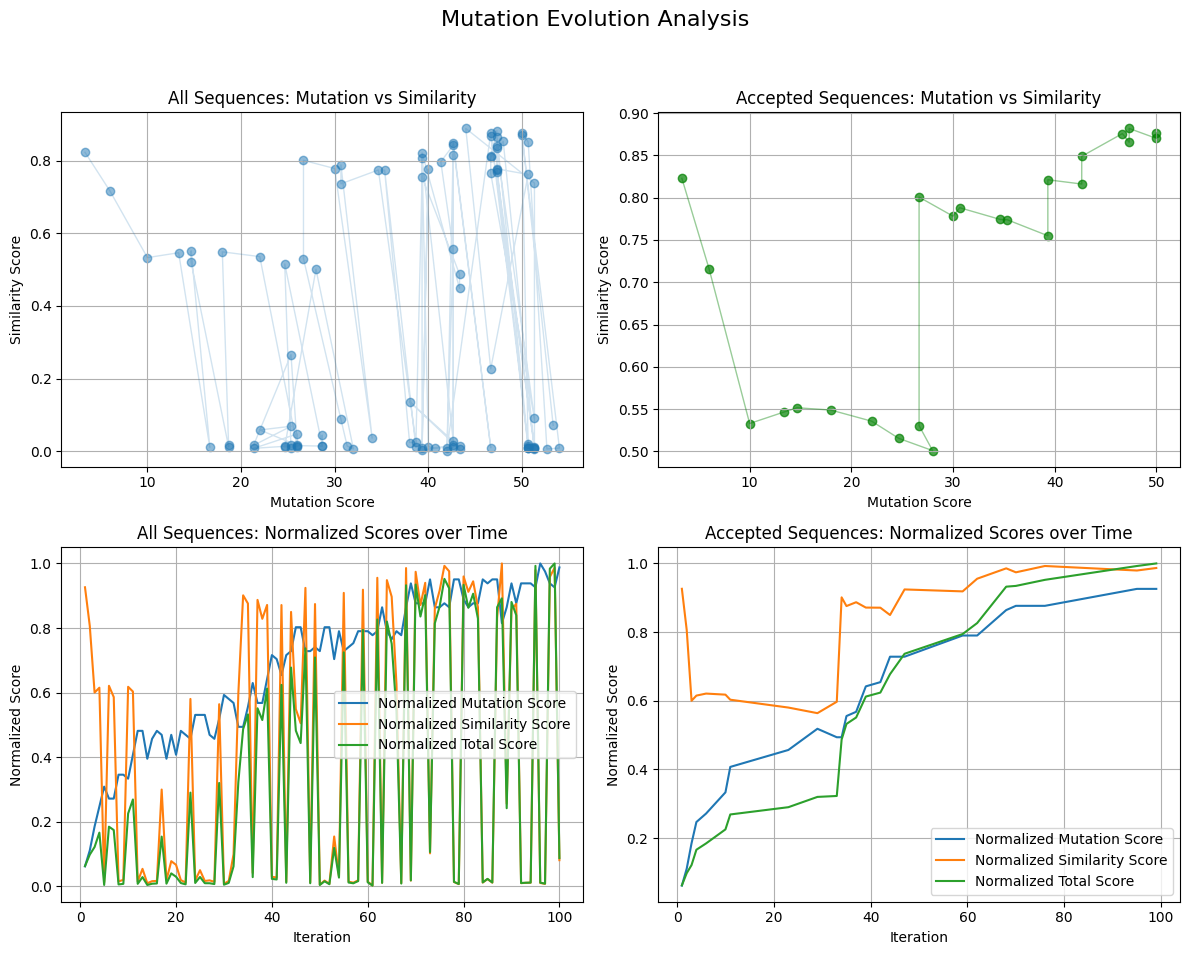

In [11]:
#@title Plot sequence history

import matplotlib.pyplot as plt
import numpy as np

# Assuming the history dictionary is loaded from the previous cell
# history = np.load(history_filename.replace('.pkl', '.npy'), allow_pickle=True).item()

all_iterations = history['all_iterations']
all_mutation_scores = history['all_mutation_scores']
all_sim_scores = history['all_sim_scores']
all_total_scores = history['all_total_scores']

accepted_iterations = history['accepted_iterations']
accepted_mutation_scores = history['accepted_mutation_scores']
accepted_sim_scores = history['accepted_sim_scores']
accepted_total_scores = history['accepted_total_scores']

# Normalize scores for the time series plots
# Find the max values across both all and accepted scores to normalize consistently
max_mutation_score = max(max(all_mutation_scores) if all_mutation_scores else 0,
                         max(accepted_mutation_scores) if accepted_mutation_scores else 0)
max_sim_score = max(max(all_sim_scores) if all_sim_scores else 0,
                    max(accepted_sim_scores) if accepted_sim_scores else 0)
max_total_score = max(max(all_total_scores) if all_total_scores else 0,
                      max(accepted_total_scores) if accepted_total_scores else 0)


normalized_all_mutation_scores = [score / max_mutation_score if max_mutation_score > 0 else 0 for score in all_mutation_scores]
normalized_all_sim_scores = [score / max_sim_score if max_sim_score > 0 else 0 for score in all_sim_scores]
normalized_all_total_scores = [score / max_total_score if max_total_score > 0 else 0 for score in all_total_scores]

normalized_accepted_mutation_scores = [score / max_mutation_score if max_mutation_score > 0 else 0 for score in accepted_mutation_scores]
normalized_accepted_sim_scores = [score / max_sim_score if max_sim_score > 0 else 0 for score in accepted_sim_scores]
normalized_accepted_total_scores = [score / max_total_score if max_total_score > 0 else 0 for score in accepted_total_scores]


fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Mutation Evolution Analysis', fontsize=16)

# Subplot 1: All sequences - Mutation vs Similarity Scatter
axes[0, 0].scatter(all_mutation_scores, all_sim_scores, alpha=0.5, label='All Mutations')
axes[0, 0].plot(all_mutation_scores, all_sim_scores, alpha=0.2, linestyle='-', linewidth=1)
axes[0, 0].set_xlabel('Mutation Score')
axes[0, 0].set_ylabel('Similarity Score')
axes[0, 0].set_title('All Sequences: Mutation vs Similarity')
axes[0, 0].grid(True)

# Subplot 2: Accepted sequences - Mutation vs Similarity Scatter
axes[0, 1].scatter(accepted_mutation_scores, accepted_sim_scores, color='green', alpha=0.7, label='Accepted Mutations')
axes[0, 1].plot(accepted_mutation_scores, accepted_sim_scores, color='green', alpha=0.4, linestyle='-', linewidth=1)
axes[0, 1].set_xlabel('Mutation Score')
axes[0, 1].set_ylabel('Similarity Score')
axes[0, 1].set_title('Accepted Sequences: Mutation vs Similarity')
axes[0, 1].grid(True)

# Subplot 3: All sequences - Scores over Time (Normalized)
axes[1, 0].plot(all_iterations, normalized_all_mutation_scores, label='Normalized Mutation Score')
axes[1, 0].plot(all_iterations, normalized_all_sim_scores, label='Normalized Similarity Score')
axes[1, 0].plot(all_iterations, normalized_all_total_scores, label='Normalized Total Score')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Normalized Score')
axes[1, 0].set_title('All Sequences: Normalized Scores over Time')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Subplot 4: Accepted sequences - Scores over Time (Normalized)
axes[1, 1].plot(accepted_iterations, normalized_accepted_mutation_scores, label='Normalized Mutation Score')
axes[1, 1].plot(accepted_iterations, normalized_accepted_sim_scores, label='Normalized Similarity Score')
axes[1, 1].plot(accepted_iterations, normalized_accepted_total_scores, label='Normalized Total Score')
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('Normalized Score')
axes[1, 1].set_title('Accepted Sequences: Normalized Scores over Time')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

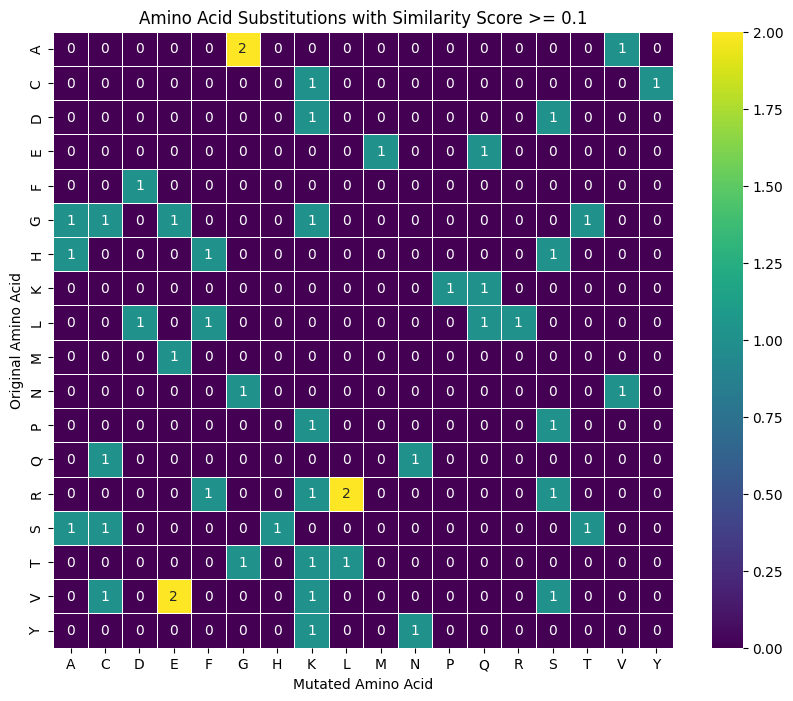

In [12]:
#@title Plot all accepted mutations

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

sim_threshold = 0.1 #@param

# Assuming the history dictionary is loaded from the previous cell
# history = np.load(history_filename.replace('.pkl', '.npy'), allow_pickle=True).item()

all_iterations = history['all_iterations']
all_sim_scores = history['all_sim_scores']
all_tried_protein_sequences = history['all_tried_protein_sequences'] # These are already protein sequences

# Filter for mutations with similarity score >= 0.8
high_similarity_mutations = []
# Iterate through all tried sequences starting from the second one (index 1)
for i in range(1, len(all_tried_protein_sequences)):
    iteration = all_iterations[i-1] # Iteration numbers correspond to the mutation *leading to* the current sequence
    previous_protein_sequence = all_tried_protein_sequences[i-1]
    current_protein_sequence = all_tried_protein_sequences[i]
    similarity_score = all_sim_scores[i-1] # Similarity score for the mutation at this iteration

    if similarity_score >= sim_threshold:
        # Find the mutated position and amino acids
        mutated_pos = -1
        original_aa = None
        mutated_aa = None
        for j in range(len(previous_protein_sequence)):
            if previous_protein_sequence[j] != current_protein_sequence[j]:
                mutated_pos = j
                original_aa = previous_protein_sequence[j]
                mutated_aa = current_protein_sequence[j]
                break # Assuming only one mutation per step

        if mutated_pos != -1:
            high_similarity_mutations.append({'original_aa': original_aa,
                                             'mutated_aa': mutated_aa,
                                             'position': mutated_pos,
                                             'similarity_score': similarity_score})

# Count the frequency of each substitution
substitution_counts = defaultdict(int)
for mutation in high_similarity_mutations:
    substitution_counts[(mutation['original_aa'], mutation['mutated_aa'])] += 1

# Create a matrix (DataFrame) for visualization
# Get all unique amino acids involved in these substitutions
all_aas = sorted(list(set([m['original_aa'] for m in high_similarity_mutations] +
                         [m['mutated_aa'] for m in high_similarity_mutations])))

substitution_matrix = pd.DataFrame(0, index=all_aas, columns=all_aas)

for (orig, mut), count in substitution_counts.items():
    substitution_matrix.loc[orig, mut] = count

# Visualize the matrix
plt.figure(figsize=(10, 8))
sns.heatmap(substitution_matrix, cmap="viridis", annot=True, fmt="d", linewidths=.5)
plt.xlabel("Mutated Amino Acid")
plt.ylabel("Original Amino Acid")
plt.title(f"Amino Acid Substitutions with Similarity Score >= {sim_threshold}")
plt.show()

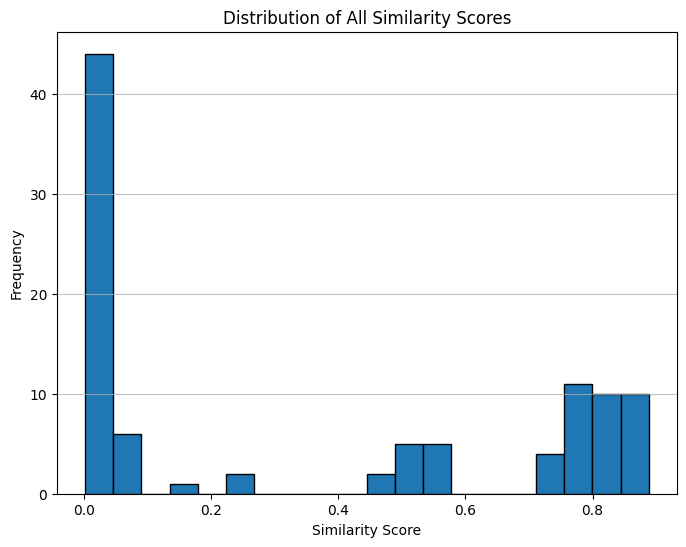

In [13]:
import matplotlib.pyplot as plt

# Assuming 'all_sim_scores' is available from the previous cell's execution
# If not, you might need to load the history again:
# history = np.load(history_filename.replace('.pkl', '.npy'), allow_pickle=True).item()
# all_sim_scores = history['all_sim_scores']

plt.figure(figsize=(8, 6))
plt.hist(all_sim_scores, bins=20, edgecolor='black')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of All Similarity Scores')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
#@title Download sequences above a total score threshold

from google.colab import files

score_threshold = 40.0 #@param{type:"number"}

# Filter sequences based on the score threshold
high_scoring_sequences = [
    seq for i, seq in enumerate(history['all_tried_protein_sequences'][1:]) # Start from index 1 to skip original
    if history['all_total_scores'][i] >= score_threshold
]

# Add the original sequence if its score (or a derived score) meets the threshold
# This assumes original_seq's score is available in history or can be calculated
# If the original sequence's score is not explicitly in all_total_scores at index 0,
# you might need to calculate it or handle it separately.
# For simplicity, let's assume the first entry in all_total_scores corresponds to the first tried sequence (index 1 in all_tried_protein_sequences)
# and the original sequence is implicitly handled if it leads to a high-scoring mutation.
# A more explicit way if needed:
# original_score = mutation_score(original_seq, original_seq) * rmsd_to_similarity(align_pred_to_ref(pdb_str, "reference.pdb")[1]) # Example calculation
# if original_score >= score_threshold and history['all_tried_protein_sequences'][0] not in high_scoring_sequences:
#    high_scoring_sequences.insert(0, history['all_tried_protein_sequences'][0])

# Add the best protein sequence if it's not already included (it should be if its score > threshold)
best_protein_sequence = history['best_protein_sequence']
if best_protein_sequence not in high_scoring_sequences and history['best_total_score'] >= score_threshold:
    high_scoring_sequences.append(best_protein_sequence)


# Create the FASTA file content
fasta_content = ""
for i, seq in enumerate(high_scoring_sequences):
    fasta_content += f">Sequence_{i+1}\n{seq}\n"

# Define the filename
fasta_filename = "high_scoring_sequences.fasta"

# Write the FASTA content to a file
with open(fasta_filename, "w") as f:
    f.write(fasta_content)

# Download the file
files.download(fasta_filename)

print(f"Created and downloaded {fasta_filename} containing {len(high_scoring_sequences)} sequences with total score >= {score_threshold}.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Created and downloaded high_scoring_sequences.fasta containing 50 sequences with total score >= 40.0.


In [ ]:
#@title Download history files

from google.colab import files
import os

# Define the history filenames
history_pkl_filename = "mutation_history.pkl"
history_npy_filename = "mutation_history.npy" # Assuming you saved the .npy as well

# Download the files if they exist
if os.path.exists(history_pkl_filename):
    files.download(history_pkl_filename)
    print(f"Downloaded {history_pkl_filename}")
else:
    print(f"{history_pkl_filename} not found.")

if os.path.exists(history_npy_filename):
    files.download(history_npy_filename)
    print(f"Downloaded {history_npy_filename}")
else:
    print(f"{history_npy_filename} not found.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded mutation_history.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded mutation_history.npy


## Identify top sequences



In [14]:
#@title Top scores
all_total_scores = history['all_total_scores']
all_tried_protein_sequences = history['all_tried_protein_sequences']
all_iterations = history['all_iterations'] # Keep track of iterations to help potentially link back

# Get indices of all scores sorted in descending order
sorted_indices = np.argsort(all_total_scores)[::-1]

# Select the top 20 indices
top_20_indices = sorted_indices[:20]

# Retrieve the top 20 protein sequences
top_20_protein_sequences = [all_tried_protein_sequences[i] for i in top_20_indices]

print("Top 20 Protein Sequences:")
for i, seq in enumerate(top_20_protein_sequences):
    print(f"{i+1}: {seq} (Score: {all_total_scores[top_20_indices[i]]:.3f})")

# Since the DNA sequences were not explicitly stored for every tried protein sequence in the history,
# and reconstructing them based solely on the protein sequence and original_seq is not straightforward
# due to silent mutations and the iterative nature, we cannot definitively link the top 20 protein
# sequences back to their exact DNA sequences from the current history structure.
# To achieve the next step of the main task (position-dependent amino acid distributions),
# we need the protein sequences themselves, which we have.
# For the subtask of finding the *DNA* sequences, we cannot complete it with the current history data structure.
# We will proceed with the protein sequences for the main task and report failure for the subtask as defined.

Top 20 Protein Sequences:
1: YKCTFGQSVFSEKKQLKRALKVHSN (Score: 43.830)
2: YKCTFGQSVHSEKKGLKRALRVHSN (Score: 43.504)
3: YKGTFGQSVFSEKKGLKRALKVHSN (Score: 43.122)
4: YKCTFGQDKFSEKKGLKRALRVHSN (Score: 41.738)
5: YCCEFGQDVFSEKKGLKRALRVHSN (Score: 40.963)
6: YKVTFGQSVFSEKKGLKRALRVHSN (Score: 40.925)
7: YKCEFGQDVFVEKKGLKRDLRVHSN (Score: 40.866)
8: YKCTFGQSVFSEKKGLKRALRVHSN (Score: 40.447)
9: YKCTFGQSVFSEKKGLLRALRVHSN (Score: 39.720)
10: YKCTFGQDVFSEKKGLKRALRVHCN (Score: 39.525)
11: YKCTFGQSVFSEKKGLKRALDVHSN (Score: 39.089)
12: YKCTFGQSVFSEKKGLKRALRVHIN (Score: 38.599)
13: YKCTFGQDVFSEKKGLKRANRVHSN (Score: 37.967)
14: YKQTFGQSVFSEKKGLKRALRVHSN (Score: 37.886)
15: YKCTFGLSVFSEKKGLKRALRVHSN (Score: 37.812)
16: YKCTFGQSVFSEKKGLKRALREHSN (Score: 36.788)
17: YKCTFGQDVFSEKKGLKRALRVHSN (Score: 36.621)
18: YKCTFGQSVFSEKKGLDRALRVHSN (Score: 36.339)
19: YKCEFGQDVFVEKKGLRRADRVHSN (Score: 36.218)
20: YKCEFGQDVFVEKKGLKRALRVLSN (Score: 35.941)


Lets see what maximum score we could expect for our protein under the current scoring

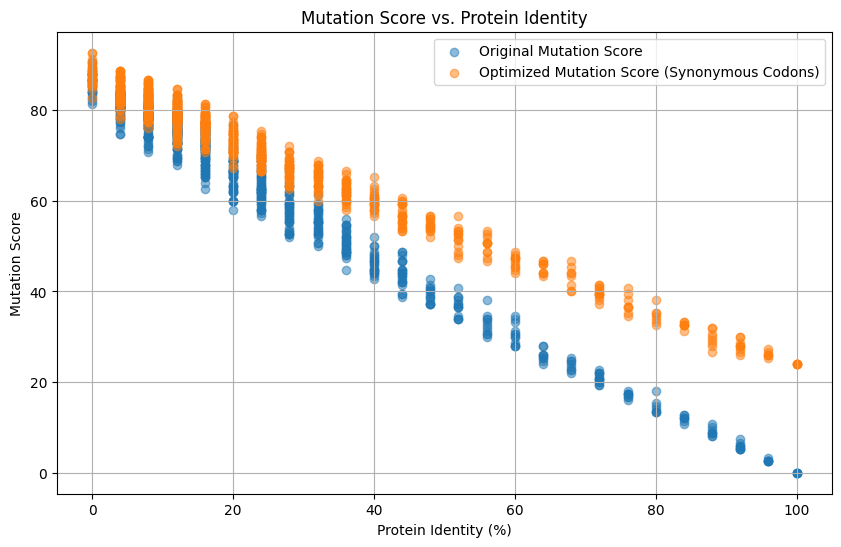

In [15]:
#@title Random mutation of original sequence
import random
import numpy as np # Import numpy

def codon_distance(codon1, codon2):
    """
    Calculate the Hamming distance between two codons.
    """
    return sum(c1 != c2 for c1, c2 in zip(codon1, codon2))

def introduce_random_mutations(original_dna_sequence: str, num_mutations: int) -> str:
    """
    Introduces a specified number of random mutations into a DNA sequence.

    Args:
        original_dna_sequence: The original DNA sequence string.
        num_mutations: The number of random mutations to introduce.

    Returns:
        A new DNA sequence string with the specified number of mutations.
    """
    dna_list = list(original_dna_sequence)
    bases = ['A', 'T', 'C', 'G']
    seq_len = len(dna_list)

    for _ in range(num_mutations):
        # Randomly select an index
        mutation_index = random.randint(0, seq_len - 1)

        # Randomly select a new base different from the current one
        current_base = dna_list[mutation_index]
        new_base = random.choice(bases)
        while new_base == current_base:
            new_base = random.choice(bases)

        # Apply the mutation to the list
        dna_list[mutation_index] = new_base

    # Convert the list back to a string and return
    return "".join(dna_list)

# 2. Initialize empty lists to store results
protein_identities = []
mutation_scores = []
opti_mutation_scores = []

repeats = 5 #@param{type:"integer"}

for iter in range(repeats):

    # 1. Define the original DNA sequence
    original_dna_seq = original_seq

    # Clean input
    original_dna_seq = original_dna_seq.replace(" ", "").upper()

    # Define a range of mutation counts
    # Let's try up to 100 mutations, as the sequence length is 96
    max_mutations = 150 #@param{type:"integer"}

    # 3. Create a loop to iterate through mutation counts
    for num_mutations in range(max_mutations + 1):
        # 4. Generate a mutated DNA sequence
        mutated_dna_seq_list = list(introduce_random_mutations(original_dna_seq, num_mutations)) # Work with a list

        # 5. Calculate the protein identity
        # Need to convert the list back to a string for translation
        mutated_dna_seq_str = "".join(mutated_dna_seq_list)
        prot_id = protein_identity(original_dna_seq, mutated_dna_seq_str)
        protein_identities.append(prot_id)

        # 6. Calculate the mutation score
        mut_score = mutation_score(original_dna_seq, mutated_dna_seq_str)

        # Optimize mutation score by looking for synonymous codons
        opti_mutated_dna_seq_list = list(mutated_dna_seq_list) # Create a copy to optimize
        num_codons = len(original_dna_seq) // 3 # Ensure num_codons is defined here
        for pos in range(num_codons):
            # Look for synonymous codons that score higher
            mutated_codon = "".join(opti_mutated_dna_seq_list[pos*3:pos*3+3]) # Get codon from list
            original_codon = original_dna_seq[pos*3:pos*3+3] # Original codon (string)

            # Handle potential issues if codon not in table (though unlikely with A,T,C,G input)
            if mutated_codon not in codon_table:
                continue

            mutated_aa = codon_table[mutated_codon]
            d = 0
            best_codon = mutated_codon
            for codon, aa in codon_table.items():
                if aa == mutated_aa:
                    d_c = codon_distance(codon, mutated_codon)
                    if d_c > d:
                        d = d_c
                        best_codon = codon

            # Apply the best codon (if a better one exists) to the optimized list
            if best_codon != mutated_codon:
                opti_mutated_dna_seq_list[pos*3:pos*3+3] = list(best_codon)


        opti_mut_score = mutation_score(original_dna_seq, "".join(opti_mutated_dna_seq_list)) # Calculate score from optimized list


        mutation_scores.append(mut_score)
        opti_mutation_scores.append(opti_mut_score)

import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(protein_identities, mutation_scores, label='Original Mutation Score', alpha=0.5)
plt.scatter(protein_identities, opti_mutation_scores, label='Optimized Mutation Score (Synonymous Codons)', alpha=0.5)

# Add title and labels
plt.title("Mutation Score vs. Protein Identity")
plt.xlabel("Protein Identity (%)")
plt.ylabel("Mutation Score")

# Add grid and legend
plt.grid(True)
plt.legend()

# Display the plot
plt.show()